In [1]:
# import packages
import glob
from pathlib import Path
import os
import numpy as np
from datetime import datetime
from datetime import timedelta
import pandas as pd
import calendar
import geopandas as gpd
import cartopy
import matplotlib.pyplot as plt
import math
from pathos.threading import ThreadPool as Pool
from scipy.optimize import least_squares
import sklearn
from sklearn.linear_model import LinearRegression
from scipy.stats import gaussian_kde
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
import random
import cartopy.crs as ccrs
from scipy.stats import gaussian_kde

In [2]:
# define your script working directory
work_dir=Path("/mnt/u/LSM root zone/global_sr/")
# work_dir=Path('/tudelft.net/staff-umbrella/LSM root zone/global_sr')

# define your data directory
data_dir=Path(f'{work_dir}/data')

out_dir=Path(f'{work_dir}/output')

### 1. map selected catchments

/tmp/ipykernel_2427/2344600985.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sh['centroid'] = sh.centroid
/tmp/ipykernel_2427/2344600985.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sh.centroid.plot(markersize=0.7,ax=ax)


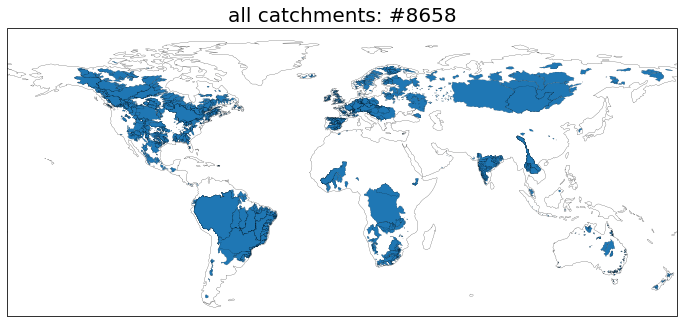

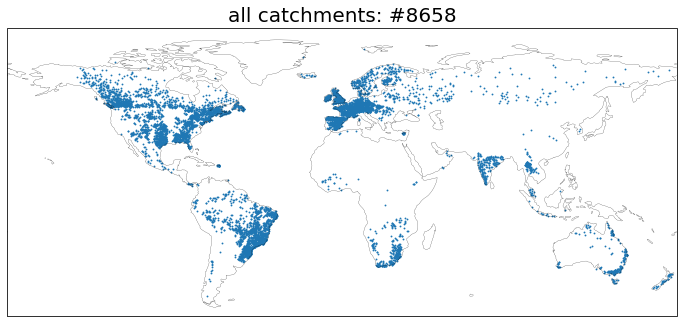

In [3]:
# map all catchments
sh = gpd.read_file(f'{out_dir}/geo_catchments.shp')
sh.index = sh.catch_id
sh['centroid'] = sh.centroid

fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.2)
sh.plot(edgecolor='black',linewidth=0.1,ax=ax)
ax.set_title(f'all catchments: #{len(sh)}',size=20)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
fig.savefig(f'{out_dir}/figures/catchment_overview/map_allcatchments_shapes.jpg',bbox_inches='tight')

fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.2)
sh.centroid.plot(markersize=0.7,ax=ax)
ax.set_title(f'all catchments: #{len(sh)}',size=20)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
fig.savefig(f'{out_dir}/figures/catchment_overview/map_allcatchments_points.jpg',bbox_inches='tight')

/tmp/ipykernel_2427/2146473660.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sh['centroid'] = sh.centroid
/tmp/ipykernel_2427/2146473660.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sh.centroid.plot(markersize=0.7,ax=ax)


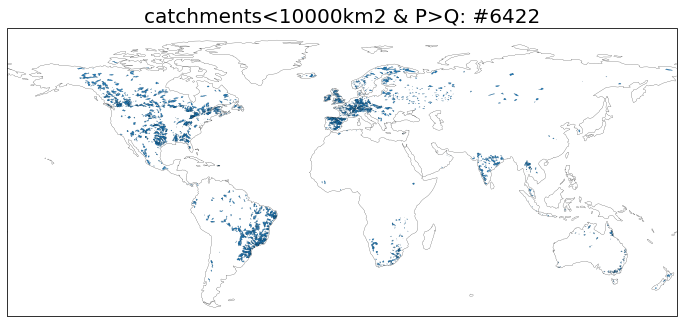

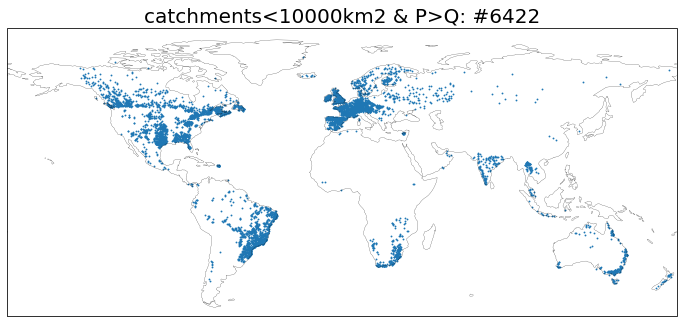

In [4]:
# map selected catchments based on area and wb
sh = gpd.read_file(f'{out_dir}/geo_catchments_sel_area_wb.shp')
sh.index = sh.catch_id
sh['centroid'] = sh.centroid

fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.2)
sh.plot(edgecolor='black',linewidth=0.05,ax=ax)
ax.set_title(f'catchments<10000km2 & P>Q: #{len(sh)}',size=20)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
fig.savefig(f'{out_dir}/figures/catchment_overview/map_selcatchments_shapes.jpg',bbox_inches='tight')

fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.2)
sh.centroid.plot(markersize=0.7,ax=ax)
ax.set_title(f'catchments<10000km2 & P>Q: #{len(sh)}',size=20)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
fig.savefig(f'{out_dir}/figures/catchment_overview/map_selcatchments_points.jpg',bbox_inches='tight')

### 2. plot catchments in budyko

In [5]:
# load selected catchment characteristics based on area and wb
c = pd.read_csv(f'{out_dir}/catchment_characteristics_sel_area_wb.csv',index_col=0)
c.head()

,p_mean,ep_mean,q_mean,t_mean,ai,si_p,si_ep,phi,tc,ntc,nonveg,area
102101A,5.013324,3.821485,2.451285,26.111414,1.311879,0.845662,0.166897,2,23.077881,64.030838,12.891281,648.4
104001A,3.615239,3.384188,1.232168,25.894186,1.068274,1.013597,0.176452,3,17.910576,67.989027,14.100397,473.7
105101A,4.120194,3.548841,0.837701,24.468281,1.160997,0.838043,0.168695,2,19.812427,64.472516,15.715056,2308.6
105102A,3.051206,3.247410,0.742289,24.834575,0.939581,0.945253,0.169238,4,14.801930,68.073281,17.124789,1322.0
105105A,5.280687,3.848386,1.194697,24.624683,1.372182,0.805871,0.181118,0,22.074308,62.859330,15.066361,296.1


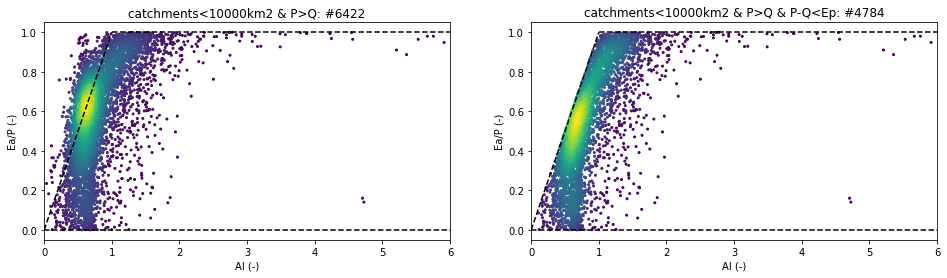

In [6]:
# plot catchments in budyko
ep = c.ep_mean
p = c.p_mean
q = c.q_mean
x = ep/p
y = (p-q)/p
x = x.dropna() # a few points with nan for AI
y = y[x.index]

# calculate point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.scatter(x,y,c=z,s=4)
ax.plot([0,1],[0,1], '--k')
ax.plot([1,12],[1,1], '--k')
ax.plot([0,12],[0,0], '--k')
ax.set_xlabel('AI (-)')
ax.set_ylabel('Ea/P (-)')
ax.set_xlim(0,6)
ax.set_ylim(-0.05,1.05)
ax.set_title(f'catchments<10000km2 & P>Q: #{len(c)}')

# plot catchments in budyko - only when Ea<Ep
cs = c[c.ep_mean>(c.p_mean-c.q_mean)]
ep = cs.ep_mean
p = cs.p_mean
q = cs.q_mean
x = ep/p
y = (p-q)/p
x = x.dropna() # a few points with nan for AI
y = y[x.index]

# calculate point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(122)
ax.scatter(x,y,c=z,s=4)
ax.plot([0,1],[0,1], '--k')
ax.plot([1,12],[1,1], '--k')
ax.plot([0,12],[0,0], '--k')
ax.set_xlabel('AI (-)')
ax.set_ylabel('Ea/P (-)')
ax.set_xlim(0,6)
ax.set_ylim(-0.05,1.05)
ax.set_title(f'catchments<10000km2 & P>Q & P-Q<Ep: #{len(cs)}')
fig.savefig(f'{out_dir}/figures/catchment_overview/budyko_selcatchments.jpg',bbox_inches='tight')


### 3. make histograms of catchment characteristics

In [7]:
c = pd.read_csv(f'{out_dir}/catchment_characteristics_sel_area_wb.csv',index_col=0)

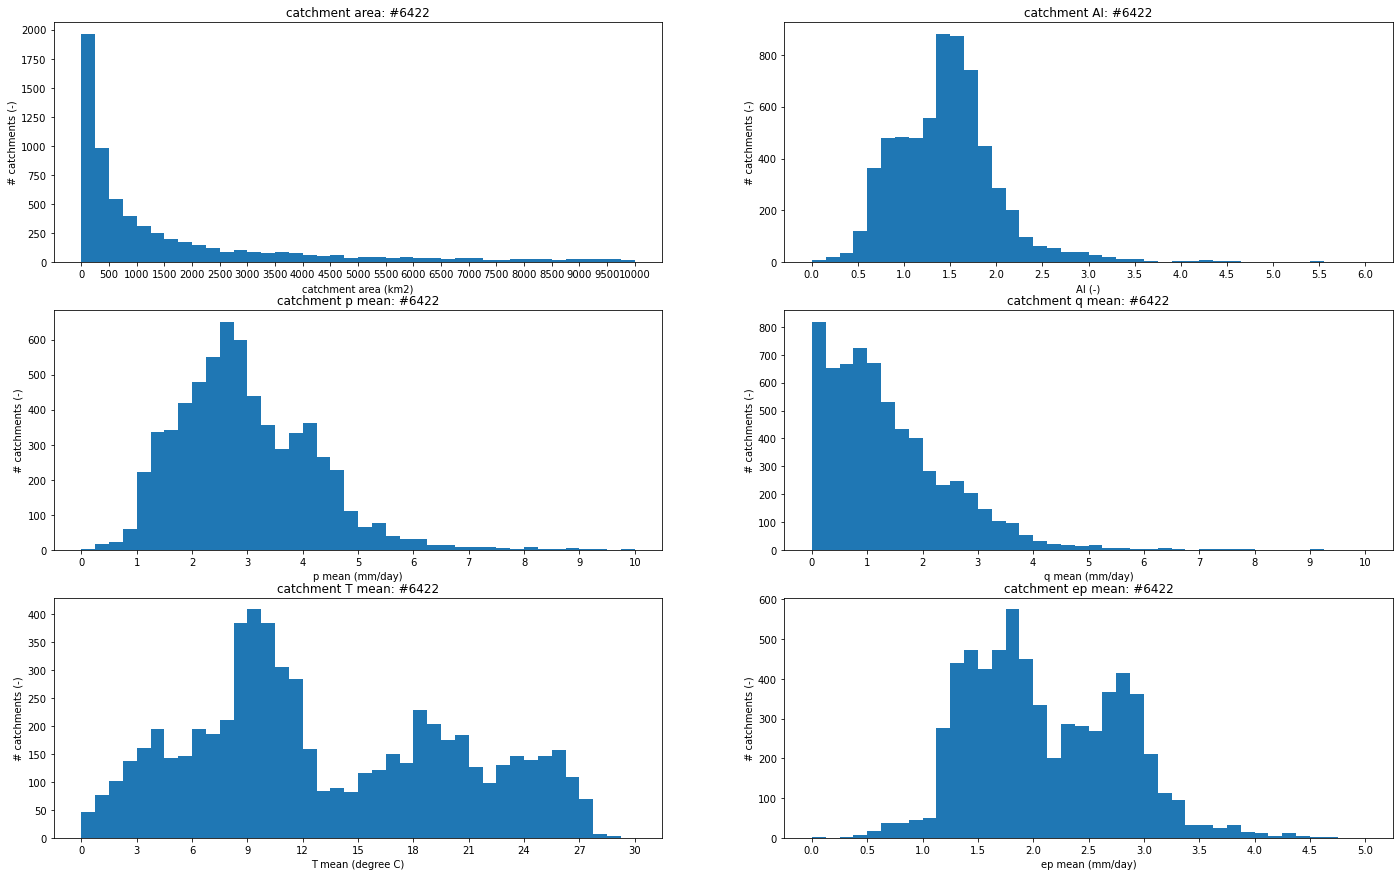

In [8]:
# area
bins = np.linspace(0,10000,41)
bins2 = np.linspace(0,10000,21)
fig = plt.figure(figsize=(24,15))
ax = fig.add_subplot(321)
ax.hist(c.area,bins=bins)
ax.set_xticks(bins2)
ax.set_xlabel('catchment area (km2)')
ax.set_ylabel('# catchments (-)')
ax.set_title(f'catchment area: #{len(c)}')

# aridity index
bins = np.linspace(0,6,41)
bins2 = np.linspace(0,6,13)
ax = fig.add_subplot(322)
ax.hist(c.ai,bins=bins)
ax.set_xticks(bins2)
ax.set_xlabel('AI (-)')
ax.set_ylabel('# catchments (-)')
ax.set_title(f'catchment AI: #{len(c)}')

# mean p
bins = np.linspace(0,10,41)
bins2 = np.linspace(0,10,11)
ax = fig.add_subplot(323)
ax.hist(c.p_mean,bins=bins)
ax.set_xticks(bins2)
ax.set_xlabel('p mean (mm/day)')
ax.set_ylabel('# catchments (-)')
ax.set_title(f'catchment p mean: #{len(c)}')

# mean q
bins = np.linspace(0,10,41)
bins2 = np.linspace(0,10,11)
ax = fig.add_subplot(324)
ax.hist(c.q_mean,bins=bins)
ax.set_xticks(bins2)
ax.set_xlabel('q mean (mm/day)')
ax.set_ylabel('# catchments (-)')
ax.set_title(f'catchment q mean: #{len(c)}')

# mean T
bins = np.linspace(0,30,41)
bins2 = np.linspace(0,30,11)
ax = fig.add_subplot(325)
ax.hist(c.t_mean,bins=bins)
ax.set_xticks(bins2)
ax.set_xlabel('T mean (degree C)')
ax.set_ylabel('# catchments (-)')
ax.set_title(f'catchment T mean: #{len(c)}')

# mean Ep
bins = np.linspace(0,5,41)
bins2 = np.linspace(0,5,11)
ax = fig.add_subplot(326)
ax.hist(c.ep_mean,bins=bins)
ax.set_xticks(bins2)
ax.set_xlabel('ep mean (mm/day)')
ax.set_ylabel('# catchments (-)')
ax.set_title(f'catchment ep mean: #{len(c)}')

fig.savefig(f'{out_dir}/figures/catchment_overview/catch_characteristics1.jpg',bbox_inches='tight')


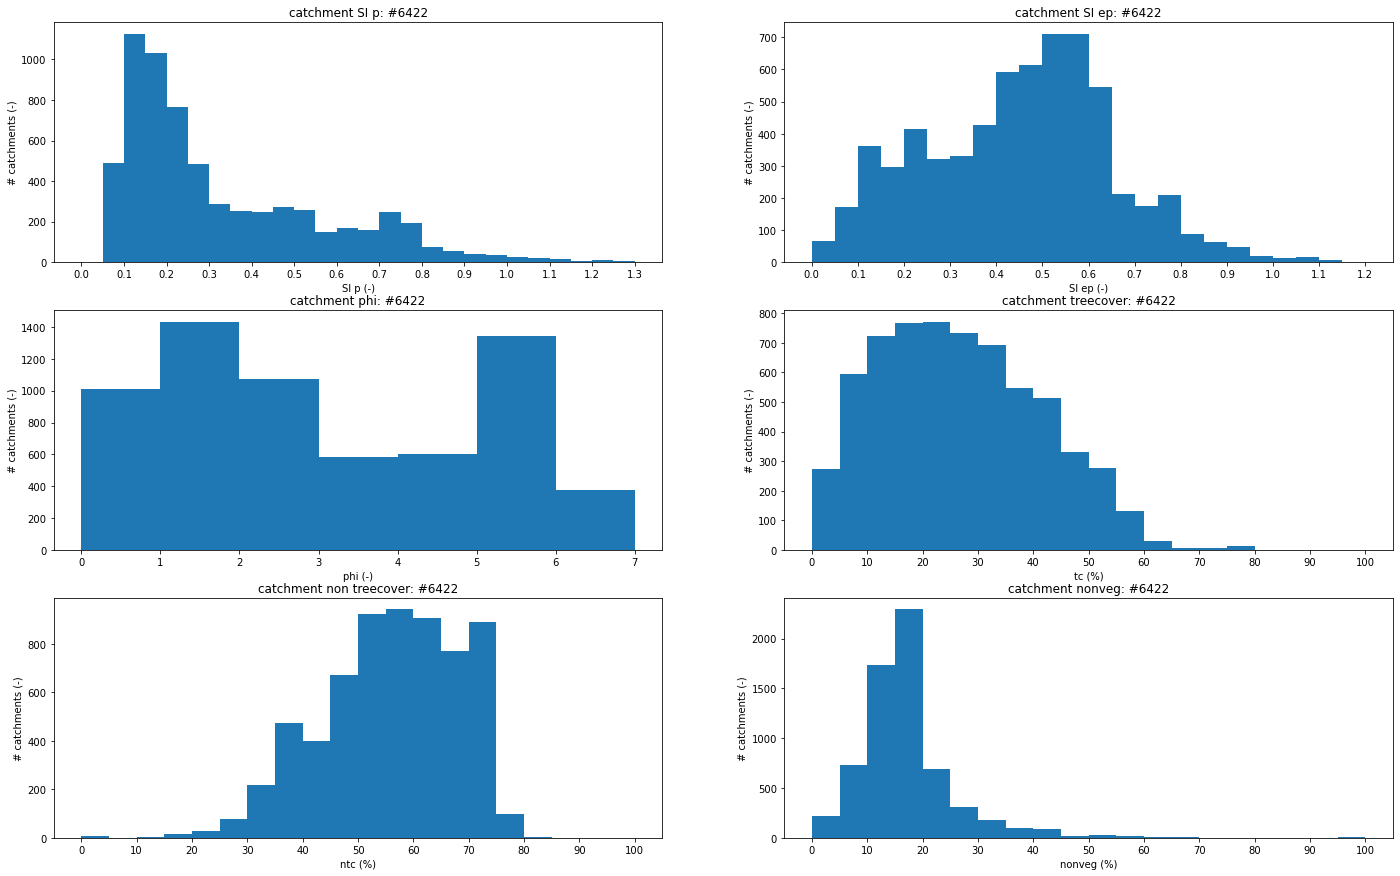

In [9]:
# si p
bins = np.linspace(0,1.3,27)
bins2 = np.linspace(0,1.3,14)
fig = plt.figure(figsize=(24,15))
ax = fig.add_subplot(321)
ax.hist(c.si_p,bins=bins)
ax.set_xticks(bins2)
ax.set_xlabel('SI p (-)')
ax.set_ylabel('# catchments (-)')
ax.set_title(f'catchment SI p: #{len(c)}')

# si ep
bins = np.linspace(0,1.2,25)
bins2 = np.linspace(0,1.2,13)
ax = fig.add_subplot(322)
ax.hist(c.si_ep,bins=bins)
ax.set_xticks(bins2)
ax.set_xlabel('SI ep (-)')
ax.set_ylabel('# catchments (-)')
ax.set_title(f'catchment SI ep: #{len(c)}')

# phi
bins = np.linspace(0,7,8)
bins2 = np.linspace(0,7,8)
ax = fig.add_subplot(323)
ax.hist(c.phi,bins=bins)
ax.set_xticks(bins2)
ax.set_xlabel('phi (-)')
ax.set_ylabel('# catchments (-)')
ax.set_title(f'catchment phi: #{len(c)}')

# tc
bins = np.linspace(0,100,21)
bins2 = np.linspace(0,100,11)
ax = fig.add_subplot(324)
ax.hist(c.tc,bins=bins)
ax.set_xticks(bins2)
ax.set_xlabel('tc (%)')
ax.set_ylabel('# catchments (-)')
ax.set_title(f'catchment treecover: #{len(c)}')

# ntc
bins = np.linspace(0,100,21)
bins2 = np.linspace(0,100,11)
ax = fig.add_subplot(325)
ax.hist(c.ntc,bins=bins)
ax.set_xticks(bins2)
ax.set_xlabel('ntc (%)')
ax.set_ylabel('# catchments (-)')
ax.set_title(f'catchment non treecover: #{len(c)}')

# nonveg
bins = np.linspace(0,100,21)
bins2 = np.linspace(0,100,11)
ax = fig.add_subplot(326)
ax.hist(c.nonveg,bins=bins)
ax.set_xticks(bins2)
ax.set_xlabel('nonveg (%)')
ax.set_ylabel('# catchments (-)')
ax.set_title(f'catchment nonveg: #{len(c)}')

fig.savefig(f'{out_dir}/figures/catchment_overview/catch_characteristics2.jpg',bbox_inches='tight')
